# PREVISÃO POR MACHINE LEARNING DA QUANTIDADE DE LEITOS DE UTI | KAGGLE | SÍRIO-LIBANÊS
- Autor: Kaique H. Valim
- Contato: kaiquevalim23@gmail.com

---
# I INTRODUÇÃO

COVID-19 vem sendo um dos assuntos mais comentados dentro e fora da comunidade científica, onde apesar das males, diversas áreas estão tendo um alavancamento tecnológico nunca antes visto, entre elas: atendimento virtual ao paciente, cruzamento de dados e inteligência artificial [1].





---


## I.1 Objetivo
O principal intuito deste trabalho é prever, através de modelos de machine learning, a quantidade de leitos de UTI necessários, com base nos dados fornecidos no site Kaggle, pelo hospital Sírio-Libanês [2].




---


## I.2 Justificativa
Como existem vagas limitadas de leitos de UTI e a criação de novas não é uma tarefa simples, é de extrema importância prever quando ocorrerá uma lotação, para que as devidas medidas devam ser tomadas, planejando recursos, tranferências de pacientes, etc.

Sendo a base de dados alocada em domínio público na internet, para segurança dos pacientes, suas identidades e outros tipos de informações que poderiam levar a sua idenficação não foram divulgadas.

O treinamento de modelos por Machine Learning é utilizado para resolver alguns dos mais diversos tipos de problemas, um deles é aplica-lo, em grande escala, em assuntos que nós humamos já somos bons, aumentando a velocidade de resolução de praticamente qualquer tipo de problema. Por esse motivo, uma análise manual dos dados disponíveis até seria possível, mas inviável pela demanda de conhecimento nos tempos atuais, tornando o aprendizado de máquina a melhor opção.


---
# II ANÁLISE






---


## II.1 Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import randint

---

## II.2 Funções

In [ ]:
def preenche_tabela(dados):
    def preenche_na(rows):
        rows.loc[rows["ICU"] != 1] = rows.loc[rows["ICU"] != 1].fillna(method='bfill').fillna(method='ffill')
        return rows
    
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[list(features_continuas_colunas) + ["ICU"]].apply(preenche_na)
    features_continuas.drop("ICU", axis=1, inplace=True)
    
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
    dados_finais.columns = dados.columns
    
    return dados_finais

In [ ]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [ ]:
def remove_corr_var(dados, valor_corte):

    matrix_corr = dados.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]
    print(excluir)
    return dados.drop(excluir, axis=1)

In [ ]:
def roda_n_modelos(modelo, dados, n):

    np.random.seed(23)

    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    auc_lista = []
    for _ in range(n):
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                            stratify=y, 
                                                            test_size = 0.30)

        modelo.fit(x_train, y_train)
        prob_predic = modelo.predict_proba(x_test)
        auc = roc_auc_score(y_test, prob_predic[:,1])
        auc_lista.append(auc)
    
    auc_medio = np.mean(auc_lista)
    auc_std = np.std(auc_lista)
    print(f'AUC {((auc_medio)*100):.2f}%')
    print(f"Intervalo {((auc_medio - 2* auc_std)*100):.2f}% ~ {((auc_medio + 2* auc_std)*100):.2f}%")

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(23)

    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, 
                              cv=cv, scoring='roc_auc', 
                              return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])
    
    print(f"AUC {((auc_medio)*100):.2f}% \nIntervalo {((auc_medio - 2* auc_std)*100):.2f}% ~ {((auc_medio + 2* auc_std)*100):.2f}%")
    return auc_medio, auc_medio_treino

In [ ]:
def roda_modelo_GridSearchCV(modelo, dados, n_splits, n_repeats, param_grid):

    np.random.seed(23)

    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

    busca = GridSearchCV(modelo, param_grid=param_grid,
                         cv = cv, scoring='roc_auc',
                         return_train_score=True)
    busca.fit(x, y)

    resultados = pd.DataFrame(busca.cv_results_).iloc[busca.best_index_]
    
    auc_medio = resultados['mean_test_score']
    auc_medio_treino = resultados['mean_train_score']
    auc_std = resultados['std_test_score']

    print(f"AUC {((auc_medio)*100):.2f}% \nIntervalo {((auc_medio - 2* auc_std)*100):.2f}% ~ {((auc_medio + 2* auc_std)*100):.2f}%")
    
    return busca, resultados

In [ ]:
def roda_modelo_RandomizedSearchCV(modelo, dados, n_splits,
                                   n_repeats, param_distributions, n_iter):

    np.random.seed(23)
    
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

    busca = RandomizedSearchCV(modelo, param_distributions=param_distributions,
                                n_iter = n_iter, cv = cv, scoring='roc_auc',
                                return_train_score=True)
    busca.fit(x, y)

    resultados = pd.DataFrame(busca.cv_results_)
    
    auc_medio = resultados.iloc[busca.best_index_]['mean_test_score']
    auc_medio_treino = resultados.iloc[busca.best_index_]['mean_train_score']

    auc_std = resultados.iloc[busca.best_index_]['std_test_score']
    
    print(f"AUC {((auc_medio)*100):.2f}% \nIntervalo {((auc_medio - 2* auc_std)*100):.2f}% ~ {((auc_medio + 2* auc_std)*100):.2f}%")
    return busca, resultados

---

## II.3 Database

**DESCRIÇÃO DOS DADOS DO KAGGLE [2] (Traduzidos)**
- Conceito de Windown
  - Tivemos o cuidado de incluir cenários da vida real com janela de eventos e dados disponíveis. Os dados foram obtidos e agrupados.

    - Paciente
      - encontro com o paciente
      - agregado por janelas em ordem cronológica

    - Descrição da janela
      - 0-2 De 0 a 2 horas da admissão
      - 2-4 De 2 a 4 horas da admissão
      - 4-6 De 4 a 6 horas da admissão
      - 6-12 De 6 a 12 horas da admissão
      - Acima de 12 anos Acima de 12 horas a partir da admissão

- Conjunto de dados
  - Este conjunto de dados contém dados anônimos do Hospital Sírio-Libanês, de São Paulo e de Brasília. Todos os dados foram tornados anônimos seguindo as melhores práticas e recomendações internacionais.
Os dados foram limpos e escalados por coluna de acordo com Min Max Scaler para caber entre -1 e 1.

- Dados disponíveis
  - Informações demográficas do paciente (03)
  - Doenças anteriores agrupadas de pacientes (09)
  - Resultados de sangue (36)
  - Sinais vitais (06)
  - No total, são 54 recursos, expandidos quando pertinentes à média, mediana, máximo, mínimo, dif e dif.

- diff = max - min
- relative diff = diff/median

In [ ]:
dados = pd.read_excel("https://github.com/KValim/bootcamp-alura-datascience/blob/master/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [ ]:
dados.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- O describe() só retorna colunas númericas, tendo retornado 229, e sendo 231 originais. Quais são essas 2?
  - AGE_PERCENTIL e WINDOW. Ambas serão tratadas a seguir.

- Pode ser notado que apesar de existirem 1925 linhas, não são 1925 pacientes, mas sim 385, indo do paciente 0 ao 384.
  - Isso explica a falta de dados NaN em diversas linhas, muito provavelmente de exames que só foram feitos em determinadas janelas.
  - Também fica evidente que na coluna ICU, é demonstrado a partir de qual janela o paciente foi mandado para a UTI

- Como visto na primeira tabela, existem diversos dados faltantes, muito provável pela falta de necessidade de tais exames em tal janela do paciente.

- Com o propósito de prever a necessidade do paciente ir para a UTI antes dele ir para a mesma, fica sem fundamento a utilização das linhas em que o paciente já está na UTI.

## II.4  Código

### NaN

- Nos treinamentos será utilizado um x com todas as colunas até WINDOW e então um y é testado para conferir se o paciente foi para UTI na coluna ICU.
  - O problema é que por enquanto existem muitos valores NaN. Como solução, será feito um agrupamento groupby() por paciente e em seguida serão preenchidos os NaN pelas funções ffill() e bfill(), que farão um autopreenchimento com os dados existentes.
  - A função também evita que o risco de que em algum dos preenchimentos sejam feitos depois da pessoa entrar na UTI.

In [ ]:
dados_limpos = preenche_tabela(dados)
dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


- Na tabela acima, pode ser visto que o problema dos NaN foi resolvido.

In [ ]:
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1770.000000,1792.000000,1794.000000,1800.000000,1800.000000,1797.000000,1770.000000,1792.000000,1794.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.778033,-0.818984,-0.912849,-0.829353,-0.775571,-0.855270,-0.788127,-0.819871,-0.912747,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.415833,0.286094,0.252406,0.289181,0.373127,0.241780,0.386193,0.284780,0.252873,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.764706,-0.714286,-0.919192,-0.735456,-0.652317,-0.771835,-0.756272,-0.715856,-0.919262,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Através da descrição da tabela, quase todas as colunas tem 1925 valores, mas especificamente faltam 5 valores nos grupos das doenças, provavelmente existe um paciente que não se enquadra em nenhum grupo de doença. Para padronizar todas as colunas com os mesmo valores, ele será removido do dataframe.

In [ ]:
dados_limpos = dados_limpos.dropna()

### WINDOW 0-2

- Como dito anteriormente, não serão utilizadas as linhas nas quais os pacientes já estão na UTI, portanto, abaixo são retirados os pacientes que foram para UTI no primeiro intervalor de tempo WINDOWN 0-2.

In [ ]:
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1537.000000,1537.000000,1537.000000,1537.00000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,...,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,193.532206,0.419649,0.375407,0.10475,0.027977,0.097593,0.018868,0.121015,0.053351,0.199089,...,-0.766543,-0.803513,-0.904322,-0.815033,-0.758142,-0.839413,-0.775592,-0.804443,-0.904295,0.160052
std,111.443169,0.493662,0.484385,0.30633,0.164959,0.296860,0.136103,0.326251,0.224805,0.399445,...,0.431038,0.295903,0.267281,0.297967,0.385381,0.252746,0.400456,0.294567,0.267501,0.366774
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,98.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,193.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,291.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.764706,-0.642857,-0.898990,-0.701863,-0.585967,-0.716187,-0.741935,-0.650579,-0.900129,0.000000
max,384.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- O próximo passo será escolher a janela que será utilizada no treinamento, e também é necessário saber se o paciente foi ou não foi para a UTI. 
  - O quanto antes melhor! A janela escolhida foi das primeras horas 0-2.

- A função abaixo irá retornar uma tabela com uma única linha por paciente, tomando como base a primeira janela de 0-2, onde se o paciente não foi para a UTI em qualquer momento, ele recebera o valor 0 em ICU e se ele foi para UTI em qualquer momento depois do período 0-2 ele receberá o valor 1 em ICU.

In [ ]:
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


### AGE_PERCENTIL

- A próxima alteração a ser feita na base de dados é a transformação da coluna *AGE_PERCENTIL* em dados categóricos, pois a idade é um fator de peso nos casos de COVID-19 e não pode ser ignorada no treinamento do modelo.

In [ ]:
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


### Correleção

- Como a base de dados tem uma grande quantidade de colunas, ou seja, muitos labels para o modelo classificar e existindo a possibilidade de correlação entre colunas. Isso siginifica que pode existir mais de uma coluna dizendo a mesma coisa, dando um peso maior, enviesando, este tipo específico de informação, atrapalhando a construção do modelo.
  - A remoção dessas colunas correlacionadas, além de evitar o overfit, pode melhorar o desempenho dos modelos.

- A correlação varia de -1 a 1. Com valores próximos de 1 significando uma correlação elevada, próximos de -1 uma correleção inversamente proporcional e valores próximos de 0 nenhuma correlação.

In [ ]:
dados_limpos.corr()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,1.000000,-0.032087,0.034343,0.073710,0.045886,-0.009823,0.034594,-0.001624,-0.001281,3.674972e-02,...,0.019970,-0.014103,0.017048,-0.008102,-0.022291,-0.011558,0.026372,-0.013863,0.019191,-0.022117
AGE_ABOVE65,-0.032087,1.000000,0.863081,0.035425,0.270215,0.050733,0.215848,0.074821,0.302722,7.727505e-03,...,-0.087377,0.015341,-0.031178,-0.038792,-0.097027,0.028059,-0.089272,0.016533,-0.031537,0.242128
AGE_PERCENTIL,0.034343,0.863081,1.000000,0.047756,0.273833,0.069132,0.172205,0.047697,0.334128,-2.839855e-02,...,-0.080338,-0.007207,-0.025395,-0.016449,-0.133453,-0.028971,-0.098463,-0.005460,-0.024215,0.283618
GENDER,0.073710,0.035425,0.047756,1.000000,0.029492,0.014196,-0.040331,-0.064592,-0.023352,-1.250825e-02,...,-0.033999,-0.016754,0.022599,0.020055,0.012625,0.067550,-0.029650,-0.017367,0.023496,-0.136548
DISEASE GROUPING 1,0.045886,0.270215,0.273833,0.029492,1.000000,0.177343,0.316506,0.035122,0.317468,2.539167e-01,...,-0.052585,-0.024466,-0.045216,-0.056285,-0.024205,0.149202,-0.059516,-0.023078,-0.046261,0.048365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HEART_RATE_DIFF_REL,-0.011558,0.028059,-0.028971,0.067550,0.149202,0.019163,0.019065,-0.053774,-0.017136,3.683078e-02,...,0.339075,0.377739,0.407795,0.440340,0.488719,1.000000,0.391595,0.379418,0.394567,-0.069849
RESPIRATORY_RATE_DIFF_REL,0.026372,-0.089272,-0.098463,-0.029650,-0.059516,0.019056,0.011691,0.040395,-0.075482,-5.563348e-02,...,0.965245,0.280631,0.395851,0.384796,0.495297,0.391595,1.000000,0.281273,0.387704,-0.004100
TEMPERATURE_DIFF_REL,-0.013863,0.016533,-0.005460,-0.017367,-0.023078,-0.045170,0.011829,0.017895,-0.098384,-4.026706e-03,...,0.235231,0.999474,0.474812,0.317000,0.416413,0.379418,0.281273,1.000000,0.463901,-0.068402
OXYGEN_SATURATION_DIFF_REL,0.019191,-0.031537,-0.024215,0.023496,-0.046261,0.121114,0.020760,-0.033468,-0.106645,-4.993585e-02,...,0.369350,0.469968,0.998826,0.556576,0.508116,0.394567,0.387704,0.463901,1.000000,0.038372


- A tabela acima só tem serventia de comparação com a tabela após o tratamento de correlação, pois existem algumas alterações a serem feitas antes da remoção das colunas.
- Não faz sentido em realizar a correlação de valores categóricos, ordinais e o de identificação do paciente, portanto estes serão desconsiderados.

In [ ]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 294 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 543.1+ KB


- Analisando as informações da tabela.
  - Os dados float64, provavelmente são resultados de exames.
  - Os outros dados int64, in8 e object, serão analisados abaixo.

In [ ]:
dados_limpos.select_dtypes(exclude='float64')

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,
0,0,0,1,5,0,0-2,1
2,10,2,0,0,0,0-2,1
3,15,3,0,3,1,0-2,0
4,20,4,0,0,0,0-2,0
5,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0-2,1
381,1905,381,1,9,0,0-2,0
382,1910,382,0,4,0,0-2,1


- Como nenhuma dessas colunas tem importância na correlação, elas não serão utilizadas.

- Abaixo é feita essa remoção.
  - Serão excluídas colunas com muita correlação e com nenhuma correlação. Para tal, somente valores absolutos são utilizados e serão excluídas correlações >= 0.95

In [ ]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos, 0.95)

['ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CREATININ_MEAN', 'CREATININ_MIN', 'CREATININ_MAX', 'FFA_MEAN', 'FFA_MIN', 'FFA_MAX', 'GGT_MEAN', 'GGT_MIN', 'GGT_MAX', 'GLUCOSE_MEAN', 'GLUCOSE_MIN', 'GLUCOSE_MAX', 'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX', 'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN', 'HEMOGLOBIN_MAX', 'INR_MEAN', 'INR_MIN', 'INR_MAX', 'LACTATE_MEAN', 'LACTATE_MIN', 'LACTATE_MAX', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN', 'LEUKOCYTES_MAX', 'LINFOCITOS_MEAN', 'LINFOCITOS_MIN', 'LINFOCITOS_MAX', 'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MIN', 'NEUTROPHILES_MAX', 'P02_ARTERIA

<ipython-input-34-ae53d3632ef2>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))


In [ ]:
dados_limpos_sem_corr.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.842105,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0-2,0


## II.5 Modelos e Métricas

In [ ]:
dados_limpos_sem_corr.shape

(294, 97)

- Serão utilizados 294 pacientes no desenvolvimento do modelo

- Para o treinamento do modelo, é de extrema importância que ele não seja treinado com a coluna de respostas ICU, evitando o enviesamento.

In [ ]:
x_columns = dados.columns

y = dados_limpos_sem_corr["ICU"]
x = dados_limpos_sem_corr.drop(["ICU","WINDOW"], axis=1)

y.value_counts()

0    189
1    105
Name: ICU, dtype: int64

### Train Test Split

- Uma prática primordinal no treinamento de modelos de machine learning, é a separação dos dados em treino e teste, para evitar o enviesamento na hora de treinar e ainda por cima testar o modelo com dados que o próprio modelo nunca viu. Esse método de treinamento se chama *Train Test Split* [5]
  - Outro fator é a proporcionalidade dos dados separados, dependendo de qual conjunto é separado para o treino, pode haver enviesamento.
    - Para corrigir será utilizada a proporção 70-30.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size = 0.30)

#### Dummy Classifier

- É importante ter uma linha de base quando desenvolvendo um modelo, para ter uma métrica se o modelo está indo bem ou não.
  - Uma forma de obter essa linha de base, é através do modelo DummieClassifier, que chuta tudo 0 ou tudo 1.

In [ ]:
np.random.seed(23)
modelo_dummy = DummyClassifier(strategy = 'most_frequent')
modelo_dummy.fit(x_train, y_train)

y_prediction = modelo_dummy.predict(x_test)

print(f'Acurácia = {(accuracy_score(y_test, y_prediction)*100):.2f}%')

Acurácia = 64.04%


- Acurácia é a variável que retorna o percentual de acertos do modelo. Sendo: accuracy = (total de acertos)/(total de dados) [3]

- Portanto é esperado um valor de previsão do modelo, pelo menos acima de 64,29%

### ROC AUC Score

- Uma curva ROC (receiver operating characteristic curve) é um gráfico que mostra o desempenho de um modelo de classificação em todos os thresholds de classificação. Apresentando dois parâmetros: Taxa de verdadeiro positivo (TRP) e Taxa de falso positivo (FPR)


- A curva AUC (Area under the ROC Curve) mede toda a área bidimensional abaixo de toda a curva ROC, como um calculo de integral, de (0,0) a (1,1).

  - Essa técnica é útil porque nos diz o quão bom é o modelo na classificação das previsões. Ela informa qual é a probabilidade de uma instância positiva escolhida aleatoriamente ter uma classificação mais alta do que uma instância negativa escolhida aleatoriamente.

#### Decision Tree Classifier

In [ ]:
roda_n_modelos(DecisionTreeClassifier(), dados_limpos_sem_corr,50)

AUC 59.99%
Intervalo 48.30% ~ 71.67%


#### Logistic Regression

In [ ]:
roda_n_modelos(LogisticRegression(max_iter = 10000), dados_limpos_sem_corr,50)

AUC 73.48%
Intervalo 64.83% ~ 82.14%


#### Random Forest Classifier

In [ ]:
roda_n_modelos(RandomForestClassifier(), dados_limpos_sem_corr,50)

AUC 75.39%
Intervalo 67.37% ~ 83.41%


- Rodando n vezes o modelo e tirando a média, reduzindo o efeito de aleatoriedade.
- Um problema sutil, é o desbalanceamento dos dados. Como o train_test_split pega linhas aleatórias do dataframe para o treinamento, qual a garantia que o conjunto de treino e teste foi baleado? E se tiverem sido pegos mais dados de pacientes que não foram para a UTI e isso tenha enviesado a decisão do modelo?

### ROC AUC Score com Cross Validade & Repeated Stratified KFold

- A validação cruzada *CROSS_VALIDADE* em conjunto com *Stratified* é utilizada para resolver este problema. Esse método condiz em separar o conjunto de dados em n partes, então escolhe uma dessas partes e a usa pra teste, ai o processo é repetido diversas vezes alternando a parte de teste. Ou seja, o método faz com que todos os dados sejam utilizados para treino e para teste, mas em momentos diferentes, obtendo a média da acurácia, aoc, etc.  
  - O StratifiedKFold, que faz o desdobramento dos dados, funcionando da seguinte forma: os dados são embaralhados, divididos em n_splits iguais e esse splits tem proporções iguais de y iguais a zeros e uns. 

#### Decision Tree Classifier

In [ ]:
roda_modelo_cv(DecisionTreeClassifier(), dados_limpos_sem_corr, 5, 10);

AUC 59.18% 
Intervalo 48.92% ~ 69.44%


#### Logistic Regression

In [ ]:
roda_modelo_cv(LogisticRegression(max_iter = 10000), dados_limpos_sem_corr, 5, 10);

AUC 73.95% 
Intervalo 63.33% ~ 84.56%


#### Random Forest Classifier

In [ ]:
roda_modelo_cv(RandomForestClassifier(), dados_limpos_sem_corr, 5, 10);

AUC 76.12% 
Intervalo 65.83% ~ 86.41%


## II.6 Overfit & Hiperparâmetros

- Essa sessão será utilizada para determinar os hiperparametros do melhor modelo encontrado até o momento (Random Forest Classifier), sem que ocorra overfit. Overfit é quando um modelo da resultados muito bons, mas somente para aquele conjunto de dados. Para lidar com ele existem métodos que serão executados a seguir.

- Hiperparâmetros: RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

### max_depth

In [ ]:
teste_lista = []
treino_lista = []
for i in range(1,10):
    teste, treino = roda_modelo_cv(RandomForestClassifier(max_depth=i), dados_limpos_sem_corr, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

AUC 76.08% 
Intervalo 64.67% ~ 87.48%
AUC 77.10% 
Intervalo 66.40% ~ 87.80%
AUC 77.43% 
Intervalo 67.07% ~ 87.79%
AUC 76.80% 
Intervalo 66.59% ~ 87.00%
AUC 77.10% 
Intervalo 66.49% ~ 87.72%
AUC 76.55% 
Intervalo 65.98% ~ 87.13%
AUC 76.34% 
Intervalo 66.06% ~ 86.62%
AUC 76.28% 
Intervalo 66.03% ~ 86.53%
AUC 76.30% 
Intervalo 65.56% ~ 87.04%


- Pelos dados acima, o max_depth recomendado é i=3, pois depois disso, há uma queda de performance.

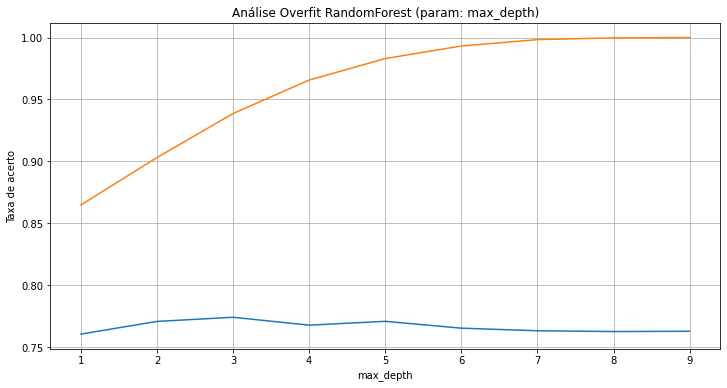

In [ ]:
x = range(1,10)

fig = plt.figure(figsize=(12,6))
ax = fig.gca()
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0.75, 1.05, 0.05))
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)
plt.title('Análise Overfit RandomForest (param: max_depth)')
plt.xlabel('max_depth')
plt.ylabel('Taxa de acerto')
plt.grid()

plt.show()

- Pela curva acima fica notável o overfit elevado com max_depth maior que 4, além de nenhum dos valores posteriores terem um resultado maior que max_depth = 3.

### n_estimators

- O RandomForrest tem um hiperparâmetro chamado n_estimators, que define quantas árvores de decisão serão utilizadas no modelo. Quanto mais árvores, mais difícil de gerar overfit e o estimador fica ainda melhor.

In [ ]:
modelo_arvore = RandomForestClassifier(max_depth=3, n_estimators=10)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC 72.49% 
Intervalo 59.57% ~ 85.41%


In [ ]:
modelo_arvore = RandomForestClassifier(max_depth=3, n_estimators=100)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC 77.43% 
Intervalo 67.07% ~ 87.79%


In [ ]:
modelo_arvore = RandomForestClassifier(max_depth=3, n_estimators=1000)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC 78.06% 
Intervalo 67.11% ~ 89.02%


- A testagem manual dos hiperparâmetros não é nem um pouco eficiente. Existem diversos métodos, diversas bibliotecas, que executam esta tarefa de forma automatizada. Duas delas são a GridSearchCV e a RandomizedSearchCV, utilizadas abaixo.

### GridSearchCV

- O GridSearchCV funciona de forma à testar todas as combinações possíveis alimentadas no dicionário abaixo. Esta é uma técnica valiosa, entretanto tem um grande custo computacional, levando muito tempo a ser executada.

In [ ]:
espaco_de_parametros = {
    "n_estimators" : [1000, 1500],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]
}

In [ ]:
modelo, resultados = roda_modelo_GridSearchCV(RandomForestClassifier(), dados_limpos_sem_corr, 5, 10, espaco_de_parametros)

AUC 78.10% 
Intervalo 67.00% ~ 89.19%


- Abaixo é retornada a combinação dos parâmetros disponíveis que obtiveram o melhor resultado.

In [ ]:
modelo.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 128,
 'n_estimators': 1500}

In [ ]:
print(f"Teste {((resultados['mean_test_score'])*100):.2f}% \nTreino {((resultados['mean_train_score'])*100):.2f}%")

Teste 78.10% 
Treino 87.42%


- O modelo retornou resultados, segundo a métrica AUC, de 78,10% com dados de teste e 87,42% com dos dados de treino.

### RandomizedSearchCV

- A RandomizedSearchCV funciona de forma similar à técnica acima, mas ela faz um número pré-definido de testagens com valores aleatórios dentro de um intervalo.

In [ ]:
espaco_de_parametros2 = {
    "n_estimators" :randint(100, 1500),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

In [ ]:
modelo, resultados = roda_modelo_RandomizedSearchCV(RandomForestClassifier(), dados_limpos_sem_corr, 5, 10, espaco_de_parametros2, 5);

AUC 75.57% 
Intervalo 64.39% ~ 86.75%


In [ ]:
modelo.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 40,
 'min_samples_split': 75,
 'n_estimators': 277}

In [ ]:
teste = resultados.iloc[modelo.best_index_]['mean_test_score']
treino = resultados.iloc[modelo.best_index_]['mean_train_score']

print(f"Teste {((teste)*100):.2f}% \nTreino {((treino)*100):.2f}%")

Teste 75.57% 
Treino 83.45%


- O modelo retornou resultados, segundo a métrica AUC, de 75,57% com dados de teste e 83,45% com dos dados de treino.

---
# III TRABALHOS FUTUROS

Aqui deixo todas as minhas vontades, que espero cumprir um dia e que sirvam de guia para quem for utilizar este notebook no futuro.

- Trabalhar com outros modelos (analisar modelos com foco em poucas amostras)
- Trabalhar com outros hiperparâmetros dos modelos utilizados
- Entrar em contato com o time do Sírio-Libanês, fazer a modelagem com a base de dados não restrita (com as doenças específicas de cada pessoa, idade, etc...)
- Aplicação web (Streamlit)
- Fazer os treinamentos com dataset separado entre homem e mulher, e entre grupos de idade. A dúvida vem dos níveis minímos e máximos dos exames, que imagino que devam variar conforme o sexo e idade
- Fazer uma análise mais profunda no filtro de autocorrelação das colunas
- Utilizar outros estimadores como skopt e hyperopt, para otimizar a busca dos melhores hiperparâmetros
- Utilizar outras métricas como F1-score e PR AUC
- Utilizar AutoML
- Criar um pipeline sólido
---

---
# IV CONCLUSÃO


O desenvolvimento deste projeto foi voltado para a construção de um modelo de machine learning que prevê, perante aos dados de um paciente, se ele necessitará de um leito de UTI. Tendo como objetivo auxiliar a tomada de decisão do responsável dos leitos de UTI do hospital.

Por meio das pesquisas e leituras realizadas no decorrer do projeto, foram arquitetados diversos modelos de machine learning, onde com base nos resultados obtidos o melhor modelo foi o RandomForestClassifier(), resultando em 78,10% de acerto nos dados de teste, segundo a métrica AUC.

Melhores parâmetros testados: 
  - {'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 40,
 'min_samples_split': 75,
 'n_estimators': 277}

A combinação dos diversos hiperparâmetros dos modelos com a base de dados fornecida resultou nas previsões demonstradas no decorrer do projeto. A implementação dos assuntos discutidos na sessão III (Trabalhos Futuros) podem elevar ainda mais a acertividade dos modelos.

---

---
# V REFERÊNCIAS


[1] Avanços tecnológicos impulsionados pela pandemia . Disponível em: https://summitsaude.estadao.com.br/tecnologia/avancos-tecnologicos-impulsionados-pela-pandemia/ . Acessado em: 17/02/2021

[2] Base de dados Kaggle. Disponível em: https://www.kaggle.com/S%C3%ADrio-Libanes/covid19 . Acessado em: 13/02/2021

[3] sklearn.metrics.accuracy_score . Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html . Acessado em: 20/02/2021

[4] Logistic regression . Disponível em: https://en.wikipedia.org/wiki/Logistic_regression . Acessado em: 20/02/2021

[5] sklearn.model_selection.train_test_split . Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html . Acessado em: 21/02/2021

---


Não alocadas
  - https://cloud.google.com/ai-platform/docs/ml-solutions-overview
  - https://www.alura.com.br/artigos/conhecendo-os-tipos-de-aprendizado-de-maquina
  - https://medium.com/data-hackers/o-que-%C3%A9-a-privacidade-diferencial-e-qual-a-rela%C3%A7%C3%A3o-com-seguran%C3%A7a-em-machine-learning-bcba0d72eba6
  - https://scikit-learn.org/stable/modules/cross_validation.html
  - https://medium.com/analytics-vidhya/what-is-a-pipeline-in-machine-learning-how-to-create-one-bda91d0ceaca
  - https://towardsdatascience.com/i-had-no-idea-how-to-build-a-machine-learning-pipeline-but-heres-what-i-figured-f3a7773513a
  - https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
  - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.10.9777&rep=rep1&type=pdf
  - https://towardsdatascience.com/workflow-of-a-machine-learning-project-ec1dba419b94
  - https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772
  - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0236618
  - https://towardsdatascience.com/what-is-p-value-short-for-no-seriously-c548200660a
  - https://www.scielo.br/scielo.php?pid=S2237-96222020000401100&script=sci_arttext&tlng=en
  - https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc